In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [179]:
def df_per_type(i) : 
    try :
        with open(f"per_point_v2/ball_data_{i}.json", "r") as f:
            data_1 = json.load(f)
        df_1 = (
            pd.DataFrame.from_dict(data_1, orient="index")
            .reset_index()
            .rename(columns={"index": "frame"}))
        df_1 = df_1.sort_values("frame")
        df_1['dx-1'] = df_1["x"].shift(1).fillna(0) - df_1['x'].shift(2).fillna(0)
        df_1['dx-'] = df_1["x"] - df_1['x'].shift(1).fillna(0)
        df_1['|dx-|'] = df_1['dx-'].abs()
        df_1['dx+'] = df_1['x'].shift(-1).fillna(0) - df_1["x"]
        df_1['|dx+|'] = df_1['dx+'].abs()
        df_1["sign_dx"] = np.sign(df_1["dx-"] * df_1["dx+"])
        df_1['dy-1'] = df_1["y"].shift(1).fillna(0) - df_1['y'].shift(2).fillna(0)
        df_1['dy-'] = df_1["y"] - df_1['y'].shift(1).fillna(0)
        df_1['|dy-|'] = df_1['dy-'].abs()
        df_1['dy+'] = df_1['y'].shift(-1).fillna(0) - df_1["y"]
        df_1['|dy+|'] = df_1['dy+'].abs()
        df_1["sign_dy"] = np.sign(df_1["dy-"] * df_1["dy+"])
        df_1["sign_dx_dy"] = np.sign(df_1["dx-"] * df_1["dy-"])
        df_1['ddx'] = df_1['dx-'] - df_1['dx+']
        df_1['ddy'] = df_1['dy-'] - df_1['dy+']
        df_1_b = df_1[df_1["action"] == 'bounce'].copy()
        df_1_h = df_1[df_1["action"] == 'hit'].copy()
        df_1_a = df_1[df_1["action"] == 'air'].copy()
        df_1_a = df_1[df_1["visible"] == True].copy()
        return df_1, df_1_a, df_1_h, df_1_b
    
    except Exception :
        print("file not found")

In [185]:
import os
folder = "per_point_v2"

json_ids = [
    int(f.split("_")[-1].split(".")[0])
    for f in os.listdir(folder)
    if f.startswith("ball_data_") and f.endswith(".json")
]


In [186]:
np.random.seed(42)
np.random.shuffle(json_ids)

split_ratio = 0.8
n_train = int(split_ratio * len(json_ids))

train_ids = json_ids[:n_train]
test_ids  = json_ids[n_train:]


In [187]:
# ===============================
# 0. IMPORTS
# ===============================

import os
import json
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier


# ===============================
# 1. LISTE DES JSON DISPONIBLES
# ===============================

FOLDER = "per_point_v2"

json_ids = [
    int(f.split("_")[-1].split(".")[0])
    for f in os.listdir(FOLDER)
    if f.startswith("ball_data_") and f.endswith(".json")
]

# ===============================
# 2. SPLIT TRAIN / TEST (80 / 20)
# ===============================

np.random.seed(42)
np.random.shuffle(json_ids)

split_ratio = 0.8
n_train = int(split_ratio * len(json_ids))

train_ids = json_ids[:n_train]
test_ids  = json_ids[n_train:]


# ===============================
# 3. FEATURES UTILISÉES
# ===============================

FEATURES = [
    'dx-', '|dx-|', 'dx+', '|dx+|',
    'dy-', '|dy-|', 'dy+', '|dy+|',
    'ddx', 'ddy',
    'sign_dx', 'sign_dy', 'sign_dx_dy'
]


# ===============================
# 4. CONSTRUCTION DU DATASET TRAIN
# ===============================

X_train, y_train = [], []

for i in train_ids:
    out = df_per_type(i)
    if out is None:
        continue

    df_all, _, _, _ = out

    df_vis = df_all[df_all["visible"] == True].copy()
    df_vis = df_vis.dropna(subset=FEATURES + ["action"])

    if len(df_vis) == 0:
        continue

    X_train.append(df_vis[FEATURES])
    y_train.append(df_vis["action"])

X_train = pd.concat(X_train, ignore_index=True)
y_train = pd.concat(y_train, ignore_index=True)


# ===============================
# 5. CONSTRUCTION DU DATASET TEST
# ===============================

X_test, y_test = [], []

for i in test_ids:
    out = df_per_type(i)
    if out is None:
        continue

    df_all, _, _, _ = out

    df_vis = df_all[df_all["visible"] == True].copy()
    df_vis = df_vis.dropna(subset=FEATURES + ["action"])

    if len(df_vis) == 0:
        continue

    X_test.append(df_vis[FEATURES])
    y_test.append(df_vis["action"])

X_test = pd.concat(X_test, ignore_index=True)
y_test = pd.concat(y_test, ignore_index=True)


# ===============================
# 6. ENCODAGE DES LABELS (XGB)
# ===============================

label_map = {"air": 0, "hit": 1, "bounce": 2}
inv_label_map = {v: k for k, v in label_map.items()}

y_train_enc = y_train.map(label_map)
y_test_enc  = y_test.map(label_map)


# ===============================
# 7. DÉFINITION DES MODÈLES
# ===============================

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)


# ===============================
# 8. RANDOM FOREST — TRAIN & TEST
# ===============================

print("\n===== RANDOM FOREST =====")

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))


# ===============================
# 9. XGBOOST — TRAIN & TEST
# ===============================

print("\n===== XGBOOST =====")

xgb.fit(X_train, y_train_enc)

y_pred_xgb = xgb.predict_proba(X_test).argmax(axis=1)
y_pred_xgb_txt = pd.Series(y_pred_xgb).map(inv_label_map)

print(classification_report(y_test, y_pred_xgb_txt, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_xgb_txt))


# ===============================
# 10. FIN
# ===============================

print("\nPipeline terminé avec succès.")



===== RANDOM FOREST =====
              precision    recall  f1-score   support

         air      0.981     0.997     0.989     24500
      bounce      0.698     0.144     0.239       305
         hit      0.670     0.372     0.478       339

    accuracy                          0.978     25144
   macro avg      0.783     0.504     0.569     25144
weighted avg      0.974     0.978     0.973     25144

Confusion matrix:
[[24428    13    59]
 [  258    44     3]
 [  207     6   126]]

===== XGBOOST =====
              precision    recall  f1-score   support

         air      0.988     0.997     0.992     24500
      bounce      0.796     0.472     0.593       305
         hit      0.702     0.493     0.579       339

    accuracy                          0.984     25144
   macro avg      0.828     0.654     0.721     25144
weighted avg      0.981     0.984     0.982     25144

Confusion matrix:
[[24419    19    62]
 [  152   144     9]
 [  154    18   167]]

Pipeline terminé avec suc

In [188]:
# ======================================
# 0. IMPORTS
# ======================================

import os
import json
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier


# ======================================
# 1. PARAMÈTRES GÉNÉRAUX
# ======================================

FOLDER = "per_point_v2"

FEATURES = [
    'dx-', '|dx-|', 'dx+', '|dx+|',
    'dy-', '|dy-|', 'dy+', '|dy+|',
    'ddx', 'ddy',
    'sign_dx', 'sign_dy', 'sign_dx_dy'
]

LABEL_MAP = {"air": 0, "hit": 1, "bounce": 2}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}


# ======================================
# 2. LISTE DES JSON DISPONIBLES
# ======================================

json_ids = sorted([
    int(f.split("_")[-1].split(".")[0])
    for f in os.listdir(FOLDER)
    if f.startswith("ball_data_") and f.endswith(".json")
])


# ======================================
# 3. CONSTRUCTION DU DATASET GLOBAL
# ======================================

X_all, y_all, groups = [], [], []

for point_id in json_ids:
    out = df_per_type(point_id)
    if out is None:
        continue

    df_all, _, _, _ = out

    df_vis = df_all[df_all["visible"] == True].copy()
    df_vis = df_vis.dropna(subset=FEATURES + ["action"])

    if len(df_vis) == 0:
        continue

    X_all.append(df_vis[FEATURES])
    y_all.append(df_vis["action"])
    groups.extend([point_id] * len(df_vis))

X_all = pd.concat(X_all, ignore_index=True)
y_all = pd.concat(y_all, ignore_index=True)
groups = np.array(groups)

y_all_enc = y_all.map(LABEL_MAP)


print("Dataset global construit")
print("X shape :", X_all.shape)
print("y distribution :")
print(y_all.value_counts(normalize=True))


# ======================================
# 4. VALIDATION CROISÉE PAR GROUPE
# ======================================

gkf = GroupKFold(n_splits=5)


# ======================================
# 5. RANDOM FOREST — GRID SEARCH
# ======================================

rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 15],
    "min_samples_leaf": [1, 5]
}

rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=gkf.split(X_all, y_all, groups),
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_all, y_all)

print("\n===== RANDOM FOREST (BEST) =====")
print("Best params :", rf_grid.best_params_)
print("Best CV F1  :", rf_grid.best_score_)


# ======================================
# 6. XGBOOST — GRID SEARCH
# ======================================

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

xgb_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}

xgb_grid = GridSearchCV(
    xgb,
    xgb_param_grid,
    cv=gkf.split(X_all, y_all_enc, groups),
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_all, y_all_enc)

print("\n===== XGBOOST (BEST) =====")
print("Best params :", xgb_grid.best_params_)
print("Best CV F1  :", xgb_grid.best_score_)


# ======================================
# 7. ÉVALUATION DÉTAILLÉE PAR FOLD (RF)
# ======================================

print("\n===== ÉVALUATION PAR FOLD (RF) =====")

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups)):
    print(f"\n--- Fold {fold + 1} ---")

    X_tr, X_te = X_all.iloc[train_idx], X_all.iloc[test_idx]
    y_tr, y_te = y_all.iloc[train_idx], y_all.iloc[test_idx]

    model = rf_grid.best_estimator_
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)

    print(classification_report(y_te, y_pred, digits=3))
    print("Confusion matrix:")
    print(confusion_matrix(y_te, y_pred))


# ======================================
# 8. ÉVALUATION DÉTAILLÉE PAR FOLD (XGB)
# ======================================

print("\n===== ÉVALUATION PAR FOLD (XGB) =====")

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all_enc, groups)):
    print(f"\n--- Fold {fold + 1} ---")

    X_tr, X_te = X_all.iloc[train_idx], X_all.iloc[test_idx]
    y_tr, y_te = y_all_enc.iloc[train_idx], y_all_enc.iloc[test_idx]

    model = xgb_grid.best_estimator_
    model.fit(X_tr, y_tr)

    y_pred = model.predict_proba(X_te).argmax(axis=1)
    y_pred_txt = pd.Series(y_pred).map(INV_LABEL_MAP)
    y_te_txt = y_all.iloc[test_idx]

    print(classification_report(y_te_txt, y_pred_txt, digits=3))
    print("Confusion matrix:")
    print(confusion_matrix(y_te_txt, y_pred_txt))


print("\nSCRIPT TERMINÉ AVEC SUCCÈS.")


Dataset global construit
X shape : (113673, 13)
y distribution :
action
air       0.973204
hit       0.014075
bounce    0.012721
Name: proportion, dtype: float64
Fitting 5 folds for each of 8 candidates, totalling 40 fits

===== RANDOM FOREST (BEST) =====
Best params : {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 200}
Best CV F1  : 0.6700613902438307
Fitting 5 folds for each of 8 candidates, totalling 40 fits

===== XGBOOST (BEST) =====
Best params : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.8}
Best CV F1  : 0.7337526892225014

===== ÉVALUATION PAR FOLD (RF) =====

--- Fold 1 ---
              precision    recall  f1-score   support

         air      0.989     0.982     0.986     22133
      bounce      0.463     0.512     0.486       289
         hit      0.453     0.632     0.528       326

    accuracy                          0.971     22748
   macro avg      0.635     0.709     0.666     22748
weighted avg  

In [192]:
# =====================================================
# 0. IMPORTS
# =====================================================

import os
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.utils import to_categorical

from hmmlearn.hmm import GaussianHMM


# =====================================================
# 1. PARAMÈTRES GÉNÉRAUX
# =====================================================

FOLDER = "per_point_v2"

FEATURES = [
    'dx-', '|dx-|', 'dx+', '|dx+|',
    'dy-', '|dy-|', 'dy+', '|dy+|',
    'ddx', 'ddy',
    'sign_dx', 'sign_dy', 'sign_dx_dy'
]

LABEL_MAP = {"air": 0, "hit": 1, "bounce": 2}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}


# =====================================================
# 2. CHARGEMENT DES SÉQUENCES (PAR JSON)
# =====================================================

X_seq, y_seq, groups = [], [], []

json_ids = sorted([
    int(f.split("_")[-1].split(".")[0])
    for f in os.listdir(FOLDER)
    if f.startswith("ball_data_") and f.endswith(".json")
])

for point_id in json_ids:
    out = df_per_type(point_id)
    if out is None:
        continue

    df_all, _, _, _ = out
    df_vis = df_all[df_all["visible"] == True].copy()
    df_vis = df_vis.dropna(subset=FEATURES + ["action"])

    if len(df_vis) < 6:
        continue

    X_seq.append(df_vis[FEATURES].values)
    y_seq.append(df_vis["action"].map(LABEL_MAP).values)
    groups.append(point_id)

print(f"Nombre de séquences : {len(X_seq)}")


# =====================================================
# 3. VALIDATION CROISÉE PAR ÉCHANGE
# =====================================================

gkf = GroupKFold(n_splits=5)


# =====================================================
# 🟦 MODEL 1 — MLP (FEATURES)
# =====================================================

print("\n===== MLP (FEATURES TEMPORELLES) =====")

X_flat = np.vstack(X_seq)
y_flat = np.hstack(y_seq)
group_flat = np.repeat(groups, [len(x) for x in X_seq])

scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    max_iter=300,
    random_state=42
)

for fold, (train_idx, test_idx) in enumerate(
    gkf.split(X_flat, y_flat, group_flat)
):
    print(f"\n--- Fold {fold + 1} ---")
    mlp.fit(X_flat[train_idx], y_flat[train_idx])
    y_pred = mlp.predict(X_flat[test_idx])
    print(classification_report(y_flat[test_idx], y_pred, digits=3))


# =====================================================
# 🟨 MODEL 2 — CNN 1D (MOTIFS TEMPORELS)
# =====================================================

def make_windows(X, y, window=7):
    Xw, yw = [], []
    for i in range(len(X) - window):
        Xw.append(X[i:i + window])
        yw.append(y[i + window])
    return np.array(Xw), np.array(yw)


print("\n===== CNN 1D (MOTIFS TEMPORELS) =====")

X_cnn, y_cnn, grp_cnn = [], [], []

for Xs, ys, g in zip(X_seq, y_seq, groups):
    Xw, yw = make_windows(Xs, ys, window=7)
    if len(Xw) == 0:
        continue
    X_cnn.append(Xw)
    y_cnn.append(yw)
    grp_cnn.extend([g] * len(yw))

X_cnn = np.vstack(X_cnn)
y_cnn = np.hstack(y_cnn)
grp_cnn = np.array(grp_cnn)

y_cnn_cat = to_categorical(y_cnn, num_classes=3)

for fold, (train_idx, test_idx) in enumerate(
    gkf.split(X_cnn, y_cnn, grp_cnn)
):
    print(f"\n--- Fold {fold + 1} ---")

    model_cnn = Sequential([
        Conv1D(32, 3, activation="relu", input_shape=X_cnn.shape[1:]),
        Conv1D(64, 3, activation="relu"),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(3, activation="softmax")
    ])

    model_cnn.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    model_cnn.fit(
        X_cnn[train_idx], y_cnn_cat[train_idx],
        epochs=5,
        batch_size=128,
        verbose=0
    )

    y_pred = model_cnn.predict(X_cnn[test_idx]).argmax(axis=1)
    print(classification_report(y_cnn[test_idx], y_pred, digits=3))


# =====================================================
# 🟥 MODEL 3 — HMM (SÉQUENTIEL PROBABILISTE)
# =====================================================

print("\n===== HMM (GAUSSIAN) =====")

hmm = GaussianHMM(
    n_components=3,
    covariance_type="full",
    n_iter=300,
    random_state=42
)

X_hmm = np.vstack(X_seq)
lengths = [len(x) for x in X_seq]

hmm.fit(X_hmm, lengths)

hidden_states = hmm.predict(X_hmm)

print("Distribution des états cachés :", np.bincount(hidden_states))


# =====================================================
# FIN
# =====================================================

print("\nSCRIPT TERMINÉ — MÉTHODES SUPERVISÉES TEMPORELLES OK")


Nombre de séquences : 313

===== MLP (FEATURES TEMPORELLES) =====

--- Fold 1 ---
              precision    recall  f1-score   support

           0      0.980     0.996     0.988     22133
           1      0.593     0.380     0.464       326
           2      0.673     0.114     0.195       289

    accuracy                          0.976     22748
   macro avg      0.749     0.497     0.549     22748
weighted avg      0.971     0.976     0.970     22748


--- Fold 2 ---
              precision    recall  f1-score   support

           0      0.979     0.996     0.987     22152
           1      0.662     0.284     0.397       317
           2      0.403     0.088     0.144       285

    accuracy                          0.975     22754
   macro avg      0.681     0.456     0.510     22754
weighted avg      0.967     0.975     0.969     22754


--- Fold 3 ---
              precision    recall  f1-score   support

           0      0.979     0.997     0.988     22076
           1   

C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step
              precision    recall  f1-score   support

           0      0.976     0.998     0.987     21714
           1      0.559     0.061     0.110       311
           2      0.575     0.149     0.237       282

    accuracy                          0.974     22307
   macro avg      0.704     0.403     0.445     22307
weighted avg      0.966     0.974     0.965     22307


--- Fold 2 ---


C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step
              precision    recall  f1-score   support

           0      0.977     0.996     0.987     21721
           1      0.358     0.094     0.149       309
           2      0.628     0.208     0.313       283

    accuracy                          0.974     22313
   macro avg      0.654     0.433     0.483     22313
weighted avg      0.964     0.974     0.967     22313


--- Fold 3 ---


C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


697/697 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step
              precision    recall  f1-score   support

           0      0.979     0.997     0.988     21679
           1      0.540     0.113     0.186       302
           2      0.652     0.346     0.452       298

    accuracy                          0.976     22279
   macro avg      0.724     0.485     0.542     22279
weighted avg      0.969     0.976     0.970     22279


--- Fold 4 ---


C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


697/697 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step
              precision    recall  f1-score   support

           0      0.979     0.998     0.988     21700
           1      0.588     0.067     0.120       299
           2      0.760     0.283     0.413       279

    accuracy                          0.977     22278
   macro avg      0.775     0.449     0.507     22278
weighted avg      0.971     0.977     0.970     22278


--- Fold 5 ---


C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step
              precision    recall  f1-score   support

           0      0.978     0.998     0.988     21746
           1      0.583     0.024     0.047       289
           2      0.586     0.215     0.314       270

    accuracy                          0.976     22305
   macro avg      0.716     0.412     0.450     22305
weighted avg      0.968     0.976     0.968     22305


===== HMM (GAUSSIAN) =====


C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

Distribution des états cachés : [98321  6971  8381]

SCRIPT TERMINÉ — MÉTHODES SUPERVISÉES TEMPORELLES OK


In [193]:
# ============================================================
# SUPERVISED HIT / BOUNCE DETECTION
# CV + FINE TUNING + 5 MODELS
# ============================================================

# =========================
# 0. IMPORTS
# =========================

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.utils import to_categorical

from hmmlearn.hmm import GaussianHMM


# =========================
# 1. PARAMÈTRES
# =========================

FOLDER = "per_point_v2"

FEATURES = [
    'dx-', '|dx-|', 'dx+', '|dx+|',
    'dy-', '|dy-|', 'dy+', '|dy+|',
    'ddx', 'ddy',
    'sign_dx', 'sign_dy', 'sign_dx_dy'
]

LABEL_MAP = {"air": 0, "hit": 1, "bounce": 2}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}


# =========================
# 2. CHARGEMENT DES SÉQUENCES
# =========================

X_seq, y_seq, groups = [], [], []

json_ids = sorted([
    int(f.split("_")[-1].split(".")[0])
    for f in os.listdir(FOLDER)
    if f.startswith("ball_data_") and f.endswith(".json")
])

for pid in json_ids:
    out = df_per_type(pid)
    if out is None:
        continue

    df_all, _, _, _ = out
    df_vis = df_all[df_all["visible"]].copy()
    df_vis = df_vis.dropna(subset=FEATURES + ["action"])

    if len(df_vis) < 6:
        continue

    X_seq.append(df_vis[FEATURES].values)
    y_seq.append(df_vis["action"].map(LABEL_MAP).values)
    groups.append(pid)

print(f"Nombre de séquences retenues : {len(X_seq)}")


# =========================
# 3. DATASET FLAT (RF / XGB / MLP)
# =========================

X_flat = np.vstack(X_seq)
y_flat = np.hstack(y_seq)
group_flat = np.repeat(groups, [len(x) for x in X_seq])

scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

gkf = GroupKFold(n_splits=5)


# ============================================================
# MODEL 1 — RANDOM FOREST (CV + GRID SEARCH)
# ============================================================

print("\n===== RANDOM FOREST =====")

rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 15],
    "min_samples_leaf": [1, 5]
}

rf_search = GridSearchCV(
    rf,
    rf_grid,
    cv=gkf.split(X_flat, y_flat, group_flat),
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_flat, y_flat)

print("Best RF params:", rf_search.best_params_)
print("Best RF CV F1:", rf_search.best_score_)


# ============================================================
# MODEL 2 — XGBOOST (CV + GRID SEARCH)
# ============================================================

print("\n===== XGBOOST =====")

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

xgb_grid = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}

xgb_search = GridSearchCV(
    xgb,
    xgb_grid,
    cv=gkf.split(X_flat, y_flat, group_flat),
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X_flat, y_flat)

print("Best XGB params:", xgb_search.best_params_)
print("Best XGB CV F1:", xgb_search.best_score_)


# ============================================================
# MODEL 3 — MLP (CV + GRID SEARCH)
# ============================================================

print("\n===== MLP =====")

mlp = MLPClassifier(
    max_iter=300,
    random_state=42
)

mlp_grid = {
    "hidden_layer_sizes": [(64,), (64, 32)],
    "alpha": [1e-4, 1e-3]
}

mlp_search = GridSearchCV(
    mlp,
    mlp_grid,
    cv=gkf.split(X_flat_scaled, y_flat, group_flat),
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

mlp_search.fit(X_flat_scaled, y_flat)

print("Best MLP params:", mlp_search.best_params_)
print("Best MLP CV F1:", mlp_search.best_score_)


# ============================================================
# MODEL 4 — CNN 1D (TIME SERIES)
# ============================================================

print("\n===== CNN 1D =====")

def make_windows(X, y, window=7):
    Xw, yw = [], []
    for i in range(len(X) - window):
        Xw.append(X[i:i+window])
        yw.append(y[i+window])
    return np.array(Xw), np.array(yw)

X_cnn, y_cnn, grp_cnn = [], [], []

for Xs, ys, g in zip(X_seq, y_seq, groups):
    Xw, yw = make_windows(Xs, ys)
    if len(Xw) == 0:
        continue
    X_cnn.append(Xw)
    y_cnn.append(yw)
    grp_cnn.extend([g] * len(yw))

X_cnn = np.vstack(X_cnn)
y_cnn = np.hstack(y_cnn)
grp_cnn = np.array(grp_cnn)

y_cnn_cat = to_categorical(y_cnn, num_classes=3)

for fold, (tr, te) in enumerate(gkf.split(X_cnn, y_cnn, grp_cnn)):
    print(f"\n--- CNN Fold {fold+1} ---")

    model = Sequential([
        Conv1D(32, 3, activation="relu", input_shape=X_cnn.shape[1:]),
        Conv1D(64, 3, activation="relu"),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(3, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(
        X_cnn[tr],
        y_cnn_cat[tr],
        epochs=5,
        batch_size=128,
        verbose=0
    )

    y_pred = model.predict(X_cnn[te]).argmax(axis=1)
    print(classification_report(y_cnn[te], y_pred, digits=3))


# ============================================================
# MODEL 5 — HMM (SÉQUENTIEL PROBABILISTE)
# ============================================================

print("\n===== HMM =====")

hmm = GaussianHMM(
    n_components=3,
    covariance_type="full",
    n_iter=300,
    random_state=42
)

X_hmm = np.vstack(X_seq)
lengths = [len(x) for x in X_seq]

hmm.fit(X_hmm, lengths)
hidden_states = hmm.predict(X_hmm)

print("Distribution des états cachés :", np.bincount(hidden_states))


# =========================
# FIN
# =========================

print("\nSCRIPT COMPLET TERMINÉ — CV + FINE TUNING OK")


Nombre de séquences retenues : 313

===== RANDOM FOREST =====
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best RF params: {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 200}
Best RF CV F1: 0.6696784619906024

===== XGBOOST =====
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.8}
Best XGB CV F1: 0.7337526892225014

===== MLP =====
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best MLP params: {'alpha': 0.001, 'hidden_layer_sizes': (64, 32)}
Best MLP CV F1: 0.5387943548827345

===== CNN 1D =====

--- CNN Fold 1 ---


C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step
              precision    recall  f1-score   support

           0      0.977     0.997     0.987     21714
           1      0.200     0.013     0.024       311
           2      0.552     0.227     0.322       282

    accuracy                          0.974     22307
   macro avg      0.576     0.412     0.444     22307
weighted avg      0.960     0.974     0.965     22307


--- CNN Fold 2 ---


C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step
              precision    recall  f1-score   support

           0      0.975     0.999     0.987     21721
           1      0.526     0.032     0.061       309
           2      0.708     0.120     0.205       283

    accuracy                          0.974     22313
   macro avg      0.737     0.384     0.418     22313
weighted avg      0.966     0.974     0.964     22313


--- CNN Fold 3 ---


C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


697/697 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step
              precision    recall  f1-score   support

           0      0.977     0.998     0.987     21679
           1      0.537     0.073     0.128       302
           2      0.716     0.228     0.346       298

    accuracy                          0.975     22279
   macro avg      0.743     0.433     0.487     22279
weighted avg      0.968     0.975     0.967     22279


--- CNN Fold 4 ---


C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


697/697 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step
              precision    recall  f1-score   support

           0      0.979     0.998     0.988     21700
           1      0.633     0.064     0.116       299
           2      0.651     0.294     0.405       279

    accuracy                          0.976     22278
   macro avg      0.754     0.452     0.503     22278
weighted avg      0.970     0.976     0.969     22278


--- CNN Fold 5 ---


C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step
              precision    recall  f1-score   support

           0      0.978     0.997     0.988     21746
           1      0.389     0.048     0.086       289
           2      0.515     0.196     0.284       270

    accuracy                          0.975     22305
   macro avg      0.627     0.414     0.453     22305
weighted avg      0.965     0.975     0.967     22305


===== HMM =====


Model is not converging.  Current: -1155155.3174798219 is not greater than -1153811.6573691366. Delta is -1343.6601106852759


Distribution des états cachés : [98754  7292  7627]

SCRIPT COMPLET TERMINÉ — CV + FINE TUNING OK


In [248]:
from sklearn.metrics import classification_report
import json
import numpy as np
import pandas as pd


def supervized_hit_bounce_detection(json_path):
    """
    - Sélectionne le meilleur modèle (RF / XGB / MLP / CNN)
    - selon la performance HIT & BOUNCE uniquement
    - enrichit le JSON avec pred_action
    - retourne (best_model_name, best_model, best_params)
    """

    # =========================
    # 1. Charger et feature-engineer le JSON
    # =========================

    point_id = int(json_path.split("_")[-1].split(".")[0])
    out = df_per_type(point_id)

    if out is None:
        raise ValueError("JSON invalide")

    df_all, _, _, _ = out
    df_vis = df_all[df_all["visible"]].copy()
    df_vis = df_vis.fillna(0)

    X = df_vis[FEATURES].values
    y_true = df_vis["action"].map(LABEL_MAP).values

    # =========================
    # 2. Liste des modèles candidats
    # =========================

    candidates = {
        "RandomForest": rf_search.best_estimator_,
        "XGBoost": xgb_search.best_estimator_,
        "MLP": mlp_search.best_estimator_
    }

    scores = {}
    predictions = {}

    # =========================
    # 3. Évaluer chaque modèle (HIT / BOUNCE ONLY)
    # =========================

    for name, model in candidates.items():

        if name == "MLP":
            X_input = scaler.transform(X)
            y_pred = model.predict(X_input)
        elif name == "XGBoost":
            y_pred = model.predict_proba(X).argmax(axis=1)
        else:
            y_pred = model.predict(X)

        report = classification_report(
            y_true,
            y_pred,
            labels=[LABEL_MAP["hit"], LABEL_MAP["bounce"]],
            output_dict=True,
            zero_division=0
        )

        f1_hit = report[str(LABEL_MAP["hit"])]["f1-score"]
        f1_bounce = report[str(LABEL_MAP["bounce"])]["f1-score"]

        scores[name] = 0.5 * (f1_hit + f1_bounce)
        predictions[name] = y_pred

    # =========================
    # 4. Sélection du meilleur modèle
    # =========================

    best_model_name = max(scores, key=scores.get)
    best_model = candidates[best_model_name]
    best_score = scores[best_model_name]
    best_pred = predictions[best_model_name]

    print(f"\n✅ Best model: {best_model_name}")
    print(f"   HIT+BOUNCE F1: {best_score:.3f}")

    # =========================
    # 5. Enrichir le JSON
    # =========================

    inv_label_map = {v: k for k, v in LABEL_MAP.items()}
    df_vis["pred_action"] = [inv_label_map[p] for p in best_pred]

    # réinjecter dans le JSON original

    df_all = df_all.merge(
        df_vis[["frame", "pred_action"]],
        on="frame",
        how="left"
    )
    df_all["pred_action"] = df_all["pred_action"].fillna("air")
    df_all = df_all[['frame','x','y','visible','action','pred_action']]
    json_data = (
        df_all.set_index("frame")
        .to_dict(orient="index")
    )

    # =========================
    # 6. Retour
    # =========================

    return json_data

In [249]:
a = supervized_hit_bounce_detection('ball_data_1.json')


✅ Best model: RandomForest
   HIT+BOUNCE F1: 0.736


In [ ]:

da = (pd.DataFrame.from_dict(a, orient="index")
            .reset_index()
            .rename(columns={"index": "frame"}))

In [ ]:
import numpy as np

def unsupervised_hit_bounce_detection(json_file_title, T_bounce=35):
    """
    Assign pred_action = hit / bounce / air
    based strictly on slope sign changes and jumps,
    following the user's stated rules.
    """
    with open(f"per_point_v2/{json_file_title}", "r") as f:
        ball_data = json.load(f)
        
    """df_ball_data = (
        pd.DataFrame.from_dict(ball_data, orient="index")
        .reset_index()
        .rename(columns={"index": "frame"}))
    
    df_ball_data = df_ball_data.sort_values("frame")
    
    df_ball_data['dx-'] = df_ball_data["x"] - df_ball_data['x'].shift(1).fillna(0)
    df_ball_data['dx+'] = df_ball_data['x'].shift(-1).fillna(0) - df_ball_data["x"]
    df_ball_data['dy-'] = df_ball_data["y"] - df_ball_data['y'].shift(1).fillna(0)
    df_ball_data['dy+'] = df_ball_data['y'].shift(-1).fillna(0) - df_ball_data["y"]"""
    

    frames = sorted(ball_data.keys())

    # Initialisation
    for f in frames:
        ball_data[f]["pred_action"] = "air"

    # Frames visibles
    vis_frames = []
    x_vals, y_vals = [], []

    for f in frames:
        d = ball_data[f]
        if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
            vis_frames.append(f)
            x_vals.append(d["x"])
            y_vals.append(d["y"])

    x_vals = np.array(x_vals, dtype=float)
    y_vals = np.array(y_vals, dtype=float)

    if len(x_vals) < 3:
        return ball_data

    dx = np.diff(x_vals)
    dy = np.diff(y_vals)

    ddx = np.diff(dx)
    ddy = np.diff(dy)

    # Parcours frame par frame
    for i in range(1, len(ddx)):
        frame = vis_frames[i + 1]

        dx_prev, dx_now = dx[i - 1], dx[i]
        dy_prev, dy_now = dy[i - 1], dy[i]

        jump_dy = abs(ddy[i])

        # -------- HIT --------
        if dx_prev * dx_now < 0 and dy_prev * dy_now < 0:
            ball_data[frame]["pred_action"] = "hit"

        # -------- BOUNCE --------
        elif (
            dx_prev * dx_now > 0 and
            dy_prev * dy_now > 0 and
            jump_dy > T_bounce
        ):
            ball_data[frame]["pred_action"] = "bounce"

        # -------- AIR --------
        else:
            ball_data[frame]["pred_action"] = "air"

    return ball_data


In [260]:
b = unsupervised_hit_bounce_detection('ball_data_1.json')

In [262]:
db = (pd.DataFrame.from_dict(b, orient="index")
            .reset_index()
            .rename(columns={"index": "frame"}))

In [264]:
db['pred_action'].value_counts()

pred_action
air       912
hit        20
bounce      5
Name: count, dtype: int64

In [265]:
db['action'].value_counts()

action
air       930
hit         4
bounce      3
Name: count, dtype: int64

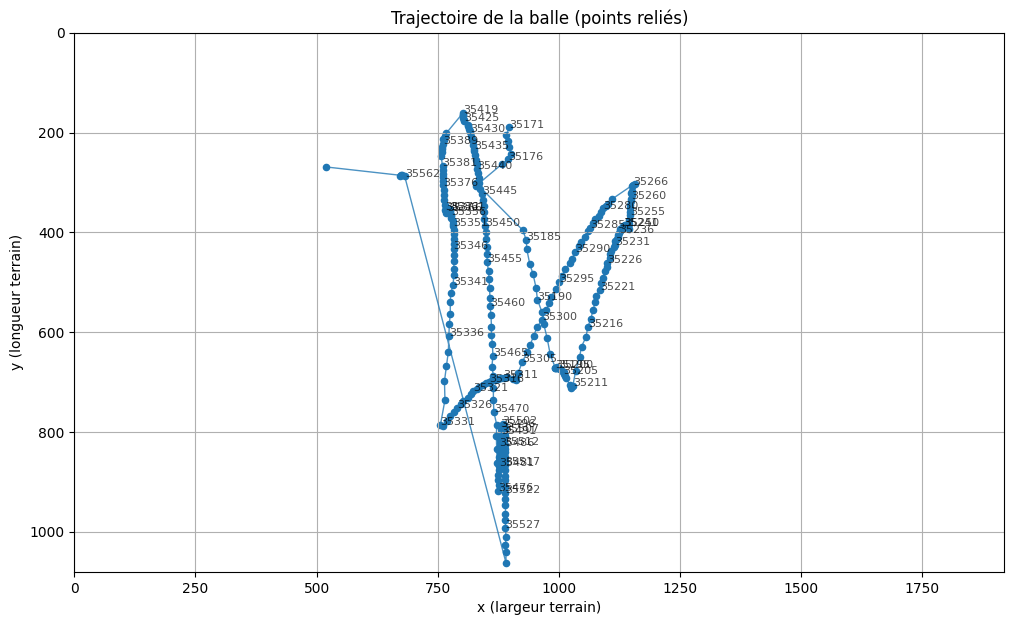

In [35]:
plt.figure(figsize=(12, 7))

# Trajectoire continue
plt.plot(
    df["x"],
    df["y"],
    linestyle="-",
    linewidth=1,
    alpha=0.8
)

# Points individuels
plt.scatter(
    df["x"],
    df["y"],
    s=20
)

# Annotation du numéro de frame (une frame sur N)
N = 5
for _, row in df.iloc[::N].iterrows():
    plt.text(
        row["x"],
        row["y"],
        str(row["frame"]),
        fontsize=8,
        alpha=0.7
    )

plt.xlim(0, 1920)
plt.ylim(1080, 0)

plt.xlabel("x (largeur terrain)")
plt.ylabel("y (longueur terrain)")
plt.title("Trajectoire de la balle (points reliés)")

plt.grid(True)
plt.show()